# Implementierung eines SNN und CNN: Ein Vergleich mit dem MNIST-Datensatz


*Author: Ümmühan Ay*

Schritt 1: Alle nötigen Imports importieren

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import time

Schritt 2: Cuda benutzen

In [2]:
device = torch.device("cuda")

Schritt 3: Implementierung des SNN und des LIF

In [3]:
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001, tau_plus=20.0, tau_minus=20.0, tau_mem=10.0, v_rest=-65.0, v_thresh=-50.0, v_reset=-65.0):
        super(SNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Synapsen-Gewichte initialisieren: (input_size, hidden_size)
        self.synapse_weights = nn.Parameter(torch.randn(input_size, hidden_size).to(device))
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.learning_rate = learning_rate
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus

        self.tau_mem = tau_mem  # Membranzeitkonstante
        self.v_rest = v_rest  # Ruhepotenzial
        self.v_thresh = v_thresh  # Schwellenwert
        self.v_reset = v_reset  # Reset-Potenzial

        # Membranpotentiale initialisieren
        self.v_hidden = torch.full((hidden_size,), self.v_rest, device="cuda")
        # STDP Zustände (Spuren für pre- und post-Spikes)
        self.pre_trace = torch.zeros(input_size, device="cuda")
        self.post_trace = torch.zeros(hidden_size, device="cuda")

    def forward(self, x, dt=1e-3):
        batch_size, time_steps, _ = x.shape
        spikes_out = torch.zeros(batch_size, time_steps, self.hidden_size, device=x.device)

        batch_size = x.shape[0]
        if self.v_hidden is None or self.v_hidden.shape[0] != batch_size:
            self.v_hidden = torch.full((batch_size, self.hidden_size), self.v_rest, device=x.device)

        for t in range(time_steps):
            z_pre = x[:, t, :]
            self.v_hidden = self.v_hidden + (self.v_rest - self.v_hidden) * (dt / self.tau_mem) + torch.matmul(z_pre, self.synapse_weights)
            z_post = (self.v_hidden > self.v_thresh).float()
            self.v_hidden = torch.where(z_post > 0, self.v_reset, self.v_hidden)
            spikes_out[:, t, :] = z_post
            self.stdp_update(z_pre, z_post, dt)

        output = self.fc2(spikes_out.sum(dim=1))
        return output

    def stdp_update(self, z_pre, z_post, dt):
        self.pre_trace = (1 - dt / self.tau_plus) * self.pre_trace + z_pre.mean(dim=0)
        self.post_trace = (1 - dt / self.tau_minus) * self.post_trace + z_post.mean(dim=0)

        hebbian = torch.ger(self.post_trace, self.pre_trace)
        anti_hebbian = torch.ger(self.pre_trace, self.post_trace)

        dw = self.learning_rate * (hebbian - anti_hebbian.T)
        dw = torch.clamp(dw, -1.0, 1.0)
        self.synapse_weights.data += dw.T


Schritt 4: MNIST-Datensatz laden

Test mit MNIST

In [4]:
# Alter Minst datensatz

# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# subset_size = 900
# train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# test_subset_size = 100
# test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# test_dataset = torch.utils.data.Subset(test_dataset, range(test_subset_size))
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Test mit Kanji-Datensatz

In [5]:
# train_data = np.load('kmnist-train-imgs.npz')['arr_0']  # 60,000 Bilder
# train_labels = np.load('kmnist-train-labels.npz')['arr_0']  # 60,000 Labels

# test_data = np.load('kmnist-test-imgs.npz')['arr_0']  # 10,000 Bilder
# test_labels = np.load('kmnist-test-labels.npz')['arr_0']  # 10,000 Labels

# class KuzushijiMNISTDataset(Dataset):
#     def __init__(self, images, labels, transform=None):
#         self.images = images
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]

#         if self.transform:
#             image = self.transform(image)

#         return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
    
# transform = transforms.Compose([transforms.ToTensor()])

# train_dataset = KuzushijiMNISTDataset(train_data, train_labels, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# test_dataset = KuzushijiMNISTDataset(test_data, test_labels, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
batch_size = 64
time_steps = 10
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# CIFAR-10 Dataset laden (train und test)
train_dataset = datasets.CIFAR10(root='./cifar-10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./cifar-10', train=False, download=False, transform=transform)
# Nur 900 Trainingsdaten & 100 Testdaten
train_subset = Subset(train_dataset, range(9000))
test_subset = Subset(test_dataset, range(1000))
# Trainings- und Test-Dataloader
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

def image_to_spikes(images, time_steps, threshold=0.5):
    spikes = torch.zeros((images.size(0), time_steps, images.size(1)), device=images.device)
    for t in range(time_steps):
        spikes[:, t, :] = (images > threshold).float()
    return spikes


Files already downloaded and verified


Schritt 5: CNN erstellen

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

        # Dropout nach der ersten Fully Connected Layer
        self.dropout = nn.Dropout(0.5)

        # BatchNorm für Convolutional Layer
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        # Convolutional Layers mit BatchNorm und ReLU
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # 32x32 → 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # 16x16 → 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # 8x8 → 4x4
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully Connected Layers mit Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout nach fc1
        x = self.fc2(x)
        return x

6. Hyperparameter, Loss-Funktion und Optimizer definieren

In [8]:
# Hyperparameter
input_size = 32 * 32 * 3  # Für CIFAR-10 Bilder
hidden_size = 512
output_size = 10
epochs = 100
time_steps = 10

snn_model = SNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
cnn_model = SimpleCNN().to(device)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

snn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
start = time.time()

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()
start_memory = torch.cuda.memory_allocated()

7. Training SNN

In [10]:
# SNN trainieren
for epoch in range(epochs):
    snn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)
        images = images.to(device)
        labels = labels.to(device)
        spikes = image_to_spikes(images, time_steps)

        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))

        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()

        running_loss += loss.item()
    
    #print(f'Epoch [{epoch+1}/{epochs}], SNN Loss: {running_loss/len(train_loader):.4f}')

In [11]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 364.06 Sekunden
Maximale GPU-Speichernutzung: 1206.24 MB


8. CNN trainieren

In [12]:
# CNN trainieren
for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        
        cnn_loss = cnn_loss_fn(outputs, labels)
        cnn_optimizer.zero_grad()
        cnn_loss.backward()
        cnn_optimizer.step()
        
        running_loss += cnn_loss.item()
    
    #print(f'Epoch [{epoch+1}/{epochs}], CNN Loss: {running_loss/len(train_loader):.4f}')

In [13]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 733.68 Sekunden
Maximale GPU-Speichernutzung: 1206.24 MB


9. SNN Evaluieren

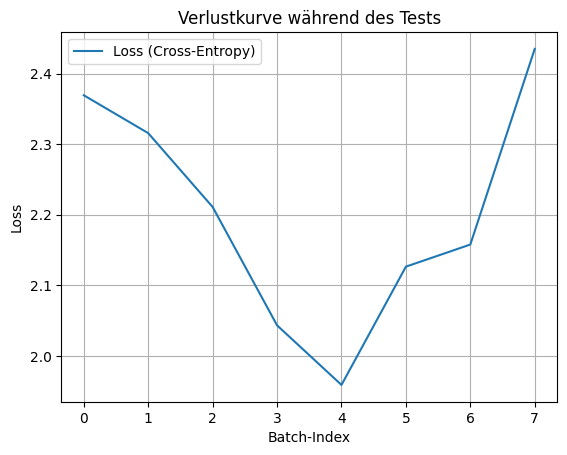

Accuracy (SNN): 23.80%


In [14]:
from matplotlib import pyplot as plt

snn_model.eval()
correct = 0
total = 0
loss_values = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        spikes = image_to_spikes(images, time_steps)
        spikes = spikes.to(device)
        
        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))
        loss_values.append(loss.item())  # Speichern des Verlusts
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

# Plot der Verlustwerte
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustkurve während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Berechnung der Genauigkeit
accuracy = 100 * correct / total
print(f'Accuracy (SNN): {accuracy:.2f}%')


10. CNN Evaluieren

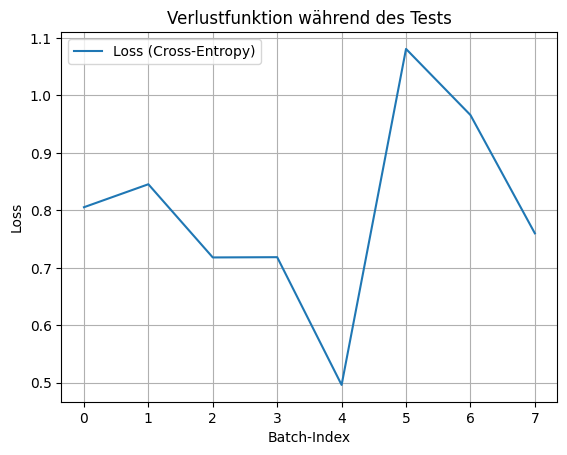

Accuracy (CNN): 75.20%


In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_values = []
cnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = loss_fn(outputs, labels)
        loss_values.append(loss.item())
    
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

# Plot der Verlustkurve
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Genauigkeit ausgeben
print(f'Accuracy (CNN): {100 * correct / total:.2f}%')
